---
title: City Nightlights
subtitle: A quick exploration for cities in Bolivia
---

*First, some dependencies and setup parameters*

In [603]:
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import geopandas as gpd
import contextily as cx
from math import ceil

In [105]:
plt.style.use('resources/other/clean.mplstyle')

In [2]:
ee.Initialize()

## Lights in space

As an initial illustration we'll work with the VIIRS monthly DNB composite on Santa Cruz de la Sierra.

To draw a map we need 

- [the VIIRS collection address in Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG)
- city centroid coordinates (*we'll improvise here, I used the computed centroid in the ONU Habitat city limits dataset.*)
- and basic visualization parameters (*I'm copying the same values in the [GEE documentation](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG)*)

In [48]:
santacruz = {"x": -63.14700, "y": -17.79393}
center = [santacruz['y'], santacruz['x']]

dnbvis = {'palette': 'magma', 'min': 0, 'max': 60}
dnb = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")

The collection starts in 2014 and is updated every month with the last image for September 2023.

We'll draw a split map comparing the median image for 2 years, for example 2015 and 2022.

In [74]:
def compare_years(start_year, end_year, center=center, zoom=10, mask=None, clip=None, basemap="CartoDB.DarkMatter"):

    start_image, end_image = [dnb.filter(ee.Filter.calendarRange(y, y, 'year')).select('avg_rad').median().set('year', y) for y in [start_year, end_year]]

    if mask:
        start_image = start_image.mask(start_image.gte(mask))
        end_image = end_image.mask(end_image.gte(mask))
        
    if clip:
        start_image = start_image.mask(start_image.clip(clip))
        end_image = end_image.mask(end_image.clip(clip))
    
    left = geemap.ee_tile_layer(start_image, dnbvis, str(start_year))
    right = geemap.ee_tile_layer(end_image, dnbvis, str(end_year))

    m = geemap.Map(
        center=center, 
        zoom=zoom, 
        basemap=basemap)

    m.split_map(
        left_layer=left,
        right_layer=right,
        left_label=str(start_year),
        right_label=str(end_year)
    )
    
    return m

In [487]:
compare_years(2015, 2022, mask=2)

Map(center=[-17.79393, -63.147], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

## Describing the lights

### A space that contains the city

To compute an analysis we'll probably need to define a consistent region. 

Here I'll just use the area within 50 km around the city centroid.

In [79]:
santacruz_buffer = ee.Geometry.Point([santacruz['x'], santacruz['y']]).buffer(50000)

To test whether this distance is reasonable we can make a map.

In [488]:
compare_years(2015, 2022, clip=santacruz_buffer, zoom=9, basemap="CartoDB.Positron")

Map(center=[-17.79393, -63.147], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

### Mean light radiance

We'll compute the mean light radiance in the city area.

To do this, we'll also need the exact resolution in these images to scale and aggregate pixel values correctly.

In [132]:
projection = ee.Image(dnb.first()).projection()
resolution = projection.nominalScale()
resolution = resolution.getInfo()

In [620]:
def timeseries(clip, reducer, scale=resolution, maxPixels=1e7):
    def reduce(img, clip):
        value = img.reduceRegion(reducer=reducer, geometry=clip, scale=scale, maxPixels=maxPixels).get('avg_rad')
        return img.set('date', img.date().format()).set('value', value)
    
    dnbReduced = dnb.map(lambda img: reduce(img, clip))
    dnbReducedList = dnbReduced.reduceColumns(ee.Reducer.toList(2), ['date', 'value']).values().get(0)
    df = pd.DataFrame(dnbReducedList.getInfo(), columns=['date','value'])
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

In [134]:
times_mean = timeseries(santacruz_buffer, ee.Reducer.mean())

Then we plot these values and their 12-month rolling mean.

In [542]:
def plotTimeseries(t, ax=None, title=None, color="#6B7BA7", rolling=True, alpha=.5, dotSize=2, lineWidth=1, label=None):
    if not ax:
        f, ax= plt.subplots(1,1,figsize=(8,4), dpi=100)
    ax.scatter(t.index, t['value'], s=dotSize, color=color, label=label if label else None)
    ax.plot(t, alpha=alpha, color=color, lw=lineWidth)
    if rolling:
        ax.plot(t.rolling(12, center=True).mean(), color='red', alpha=.5, lw=.8)
    ax.grid()
    ax.set_ylabel('nanoWatts/sr/cm2', labelpad=8)
    if title:
        ax.annotate(title, (0,1), xycoords='axes fraction', fontfamily="Archivo", fontsize=10, va="top")

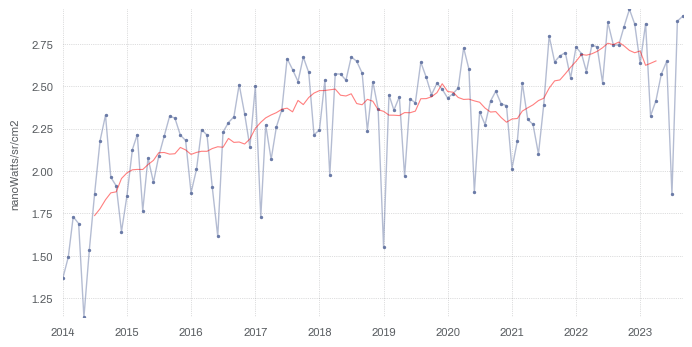

In [543]:
plotTimeseries(times_mean)

### Sum of lights

We can also compute and plot the sum of lights in the area.

In [136]:
times_sum = timeseries(santacruz_buffer, ee.Reducer.sum())

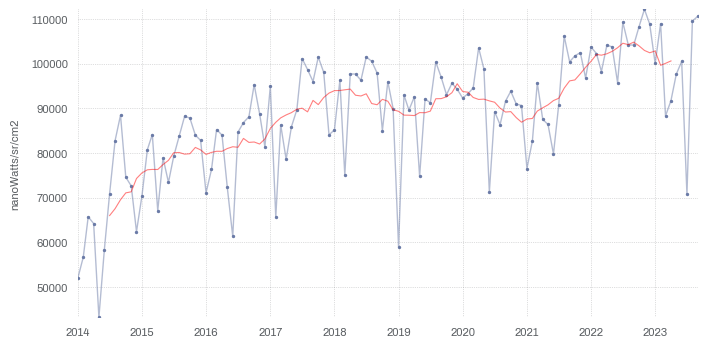

In [532]:
plotTimeseries(times_sum)

### Light distributions

Instead of compressing every image into a single value, we can plot the light distribution across all pixels. 

For example, we can compute the distribution for the median image in 2016, 2019 and 2022.

In [157]:
def yearDist(year, clip, scale=resolution, crs=projection):

    dnbYear = dnb.filter(ee.Filter.calendarRange(year, year, 'year')).select('avg_rad').median()
    dnbArray = dnbYear.reduceRegion(reducer=ee.Reducer.toList(), geometry=clip, scale=scale, crs=crs).get('avg_rad')
    return np.array(dnbArray.getInfo())

In [260]:
dist16, dist19, dist22 = [yearDist(y, santacruz_buffer) for y in [2016, 2019, 2022]]

Then plot yearly log values grouped in bins.

In [473]:
def plotYearDist(dists, colors, log=True, barAlpha=.2, ):
    
    n = 100
    f, ax = plt.subplots(1,1,figsize=(8,4), dpi=100)
    
    if log:
        dists = np.log(dists)

    max_value = np.nanmax([d.max() for d in dists])
    min_value = np.nanmin([d.min() for d in dists])
    
    bins = [(i / (n / (max_value - min_value))) + min_value for i in range(n)]
    
    for dist, color in zip(dists, colors):
        df = pd.Series(dist)
        df = pd.cut(df.dropna(), bins=bins).value_counts().sort_index()
        df.index = [_.left for _ in df.index.tolist()]
        barWidth = ((df.index.max() - df.index.min()) / 100) * .7
        ax.bar(df.index, df, width=barWidth, alpha=barAlpha, color=color)
    
    ax.grid(axis='y')

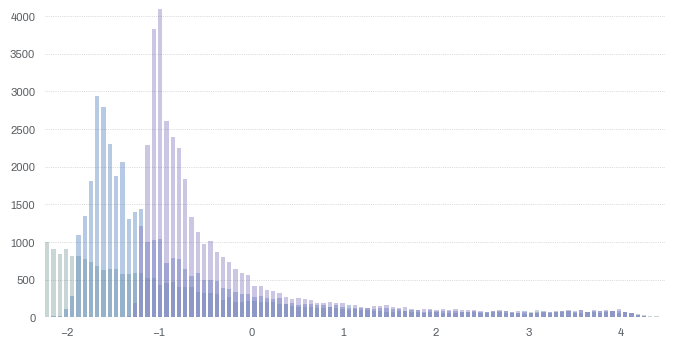

In [486]:
plotYearDist([dist16, dist19, dist22], ['#769c97', '#4b7bbd', '#8171bf'], barAlpha=.4)

## Timeseries for every major city in Bolivia

### Better city polygons

I'd like to compute mean and sum time series for every major city in Bolivia. 

These estimates are highly susceptible to the definition of city limits. 

So, I'll use the urban shapes published by the Joint Research Center at the European Commission in the [Urban Center Database R2019A](https://ghsl.jrc.ec.europa.eu/ghs_stat_ucdb2015mt_r2019a.php). These are the result of thresholds on degrees of urbanization estimated through settlements detected in satellite images and a gridded census dataset.

The resolution of these shapes is pretty low (1 km), so I'll draw a convex hull 5km around the edges of the city to define more reasonable limits.

These are the cities in the dataset:

In [269]:
ciudades = gpd.read_file('resources/ghs_ucdb_extract/bolivia.geojson')
ciudades['buffer'] = ciudades.to_crs('32719').convex_hull.buffer(5e3).to_crs(ciudades.crs)
ciudades

,name,geometry,buffer
0,El Alto; La Paz,"MULTIPOLYGON (((-68.15658 -16.43993, -68.13610...","POLYGON ((-68.15437 -16.66835, -68.15867 -16.6..."
1,Caranavi,"MULTIPOLYGON (((-67.57606 -15.82396, -67.55562...","POLYGON ((-67.50302 -15.84924, -67.50414 -15.8..."
2,Riberalta,"MULTIPOLYGON (((-66.08549 -10.99276, -66.03502...","POLYGON ((-65.99537 -11.03961, -65.99617 -11.0..."
3,Oruro,"MULTIPOLYGON (((-67.12401 -17.91312, -67.11372...","POLYGON ((-67.11274 -18.04749, -67.11668 -18.0..."
4,Cochabamba; Sacaba; Quillacollo; Colcapirhua; ...,"MULTIPOLYGON (((-66.22786 -17.32001, -66.21759...","POLYGON ((-66.15733 -17.53508, -66.16141 -17.5..."
5,Trinidad,"MULTIPOLYGON (((-64.90785 -14.80711, -64.86710...","POLYGON ((-64.86358 -14.88795, -64.86696 -14.8..."
6,Potosí,"MULTIPOLYGON (((-65.76960 -19.55643, -65.75925...","POLYGON ((-65.69652 -19.62485, -65.69779 -19.6..."
7,Sucre,"MULTIPOLYGON (((-65.26225 -19.01073, -65.25192...","POLYGON ((-65.22633 -19.09719, -65.23043 -19.0..."
8,Tarija,"MULTIPOLYGON (((-64.75447 -21.49701, -64.74404...","POLYGON ((-64.64042 -21.56647, -64.64188 -21.5..."
9,Montero,"MULTIPOLYGON (((-63.25017 -17.32001, -63.23990...","POLYGON ((-63.21121 -17.39780, -63.21528 -17.4..."


To illustrate the fit of these polygons over the city, I'll draw these shapes:

In [293]:
def plotCityBounds(name):
    f, ax = plt.subplots(1,1,figsize=(8,8), dpi=100)
    city = ciudades[ciudades.name == name]
    city.plot(ax=ax, color=(0,0,1,.05), edgecolor=(0,0,1,.5))
    city['buffer'].plot(ax=ax, color=(0,0,1,.05), edgecolor=(0,0,1,.5))
    ax.set_axis_off()
    cx.add_basemap(
        ax=ax,
        attribution='',
        crs=ciudades.crs,
        source=cx.providers.CartoDB.Positron
    )

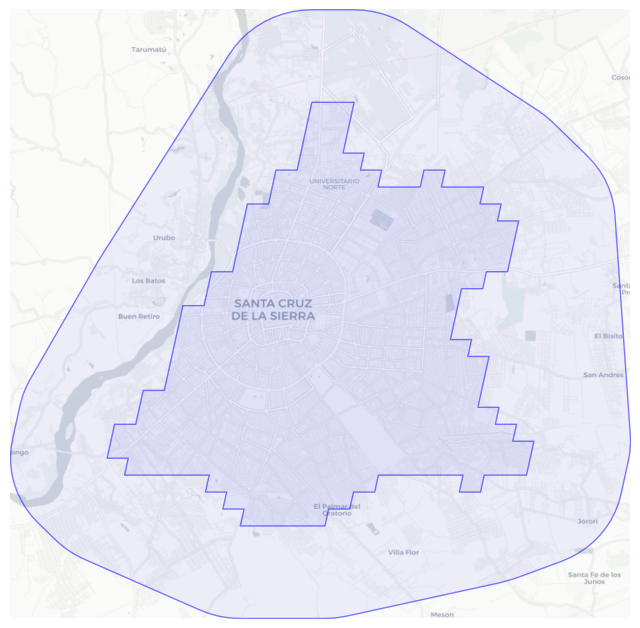

In [294]:
plotCityBounds('Santa Cruz de la Sierra')

If we estimate the mean lights timeseries for the outer shape, it looks pretty similar to the one we computed before. 

The vertical scale looks different because, compared to the previous series, this one features a lot fewer empty areas.

In [300]:
ciudades = geemap.gdf_to_ee(gpd.GeoDataFrame(ciudades[['name', 'buffer']], geometry='buffer'))

In [301]:
times_mean_ciudad = timeseries(ciudades.filterMetadata('name', 'equals', 'Santa Cruz de la Sierra'), ee.Reducer.mean())

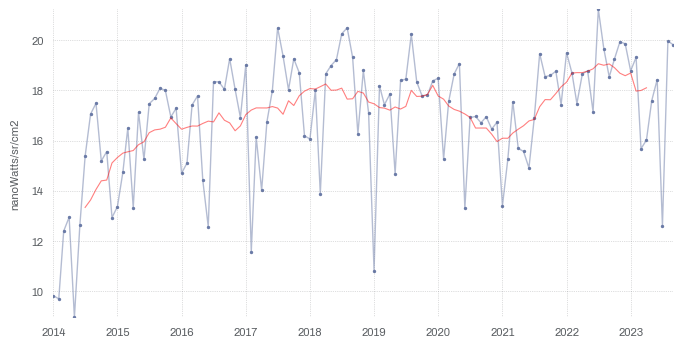

In [533]:
plotTimeseries(times_mean_ciudad)

### Mean light radiance for every city

We repeat this exercise for every city.

In [386]:
def collectionTimeseries(collection, reducer, scale=resolution):
    
    def reduce(img, collection):
        return img.reduceRegions(reducer=reducer, collection=collection, scale=scale)
    
    reduced = dnb.map(lambda img: reduce(img, collection)).flatten()
    dates = dnb.map(lambda img: img.set('date', img.date().format()))
    
    citylist = reduced.reduceColumns(ee.Reducer.toList(2), ['name', 'avg_rad']).values()
    dateslist = dates.reduceColumns(ee.Reducer.toList(1), ['date']).values()
    
    df = pd.DataFrame(np.asarray(citylist.getInfo()).squeeze(), columns=['ciudad', 'value'])
    datesarray = np.asarray(dateslist.getInfo()).squeeze()
    
    for ciudad in df.ciudad.unique():
        df.loc[df.ciudad == ciudad, 'date'] = datesarray
    df['date'] = pd.to_datetime(df['date'])
    df.value = df.value.astype(float)
    
    return df[['ciudad', 'date', 'value']]

In [372]:
ciudades_mean = collectionTimeseries(ciudades, ee.Reducer.mean())

In [374]:
ciudades_mean

,ciudad,value,date
0,El Alto; La Paz,8.052149458354055,2014-01-01
1,Caranavi,0.2670227550758099,2014-01-01
2,Riberalta,0,2014-01-01
3,Oruro,6.4223890486344715,2014-01-01
4,Cochabamba; Sacaba; Quillacollo; Colcapirhua; ...,9.29696169003235,2014-01-01
...,...,...,...
1282,Potosí,14.983109521143724,2023-09-01
1283,Sucre,15.266338127181777,2023-09-01
1284,Tarija,10.343679590501477,2023-09-01
1285,Montero,5.698692637821926,2023-09-01


And plot the results.

In [410]:
def plotTimeseriesCollection(collection, ciudad_col='ciudad', cols=2):
    
    names = collection[ciudad_col].unique()
    rows = ceil(len(names)/cols)
    
    f, axs = plt.subplots(rows,cols,figsize=((cols * 6), (rows * 3)), dpi=100)
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        if i >= len(names):
            ax.set_axis_off()
        else:
            name = names[i]
            plotTimeseries(collection[collection[ciudad_col] == name].set_index('date')[['value']], ax=ax, title=name)
            
    plt.tight_layout()

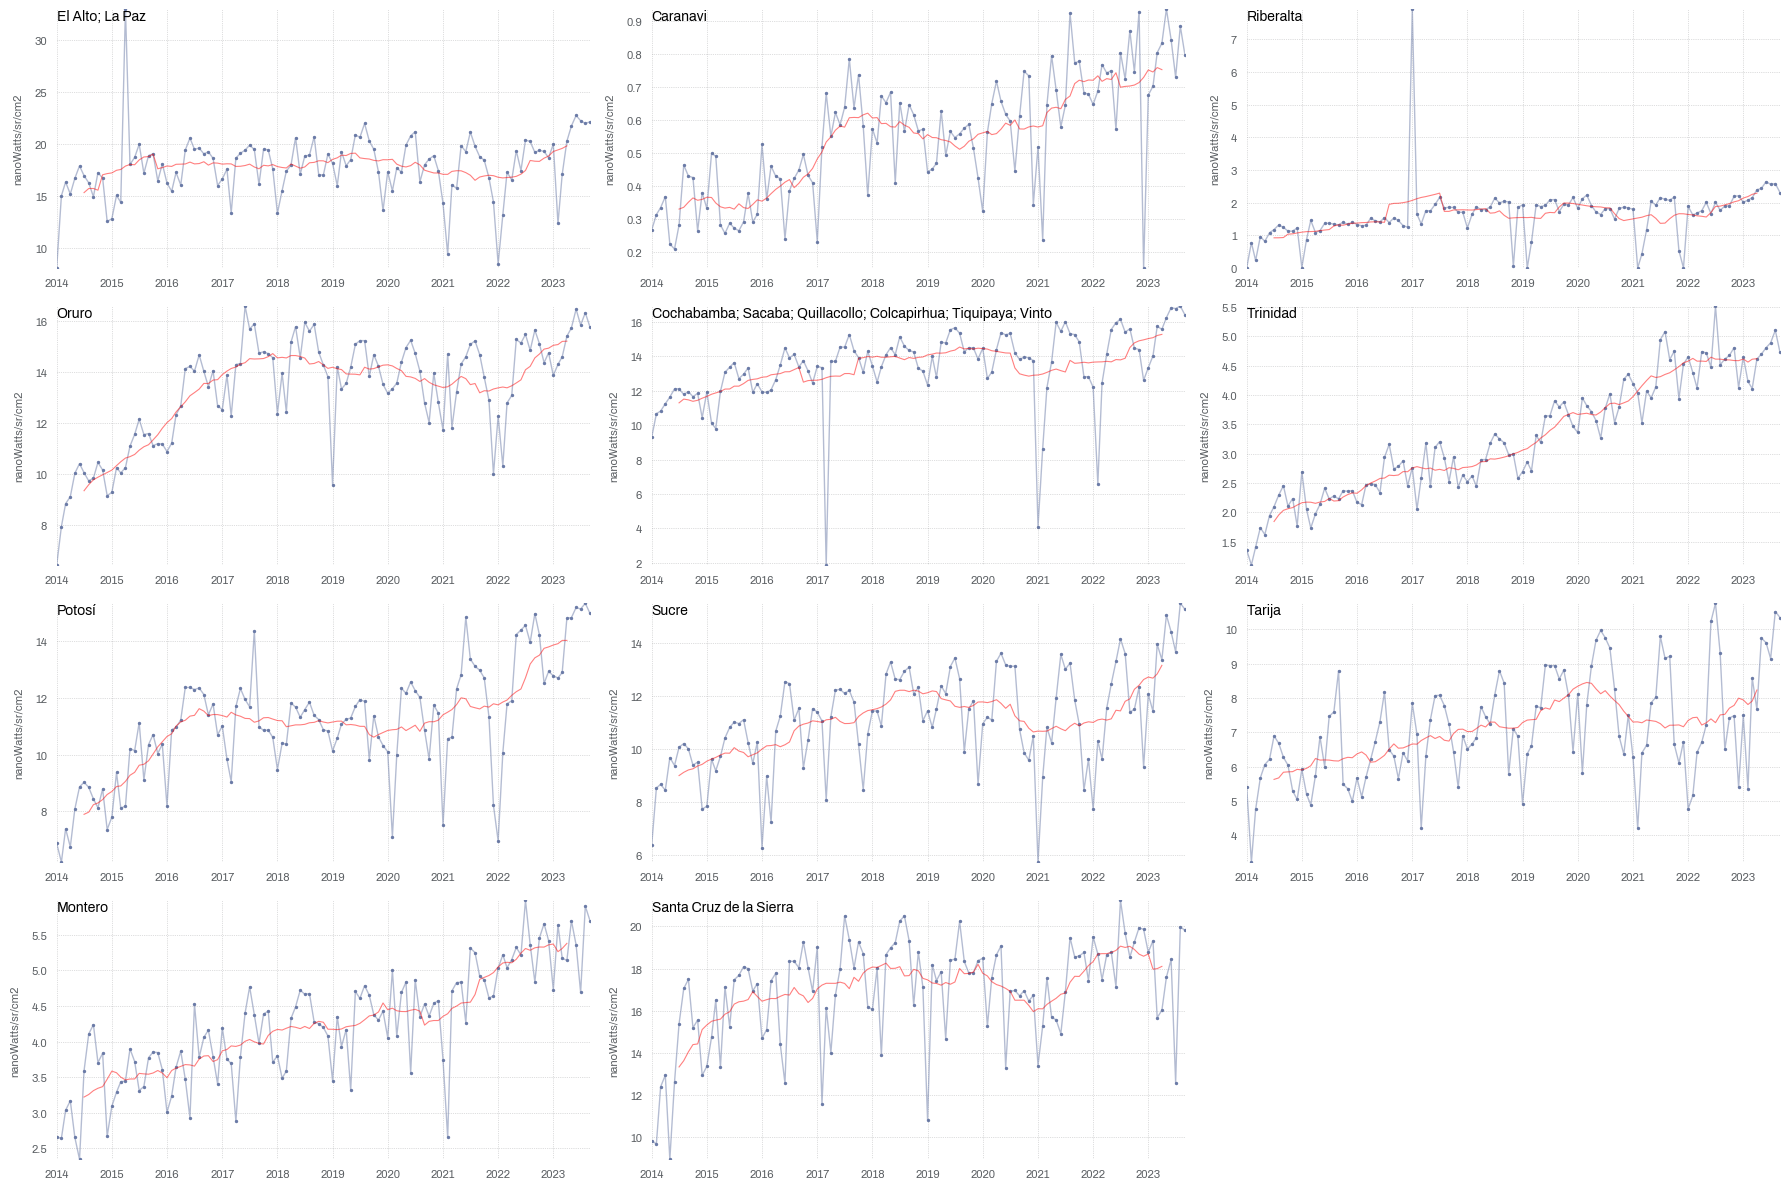

In [534]:
plotTimeseriesCollection(ciudades_mean, cols=3)

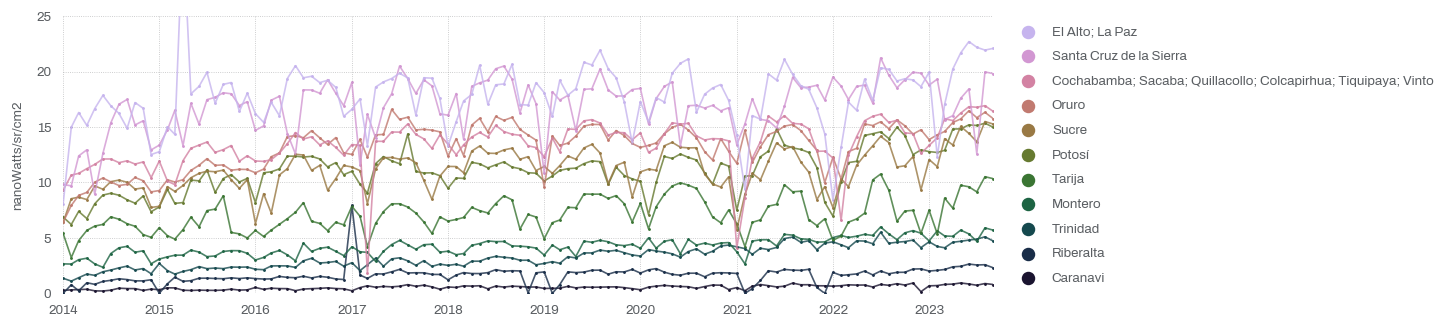

In [605]:
def plotTimeseriesCollectionJoined(collection, ciudad_col='ciudad', max_y=None):
    
    order = collection[collection.date == collection.date.max()].sort_values('value')[ciudad_col].tolist()
    colors = plt.get_cmap('cubehelix')(np.linspace(.1,.75,len(collection[ciudad_col].unique())))
    
    f, ax = plt.subplots(1,1,figsize=(10, 3), dpi=120)
    
    for ciudad, color in zip(order, colors):
        plotTimeseries(collection[collection[ciudad_col] == ciudad].set_index('date')[['value']], ax=ax, color=color, rolling=False, dotSize=.5, label=ciudad, alpha=.8)
    
    if max_y:
        ax.set_ylim([0, max_y])
    
    ax.legend(bbox_to_anchor=(1.01, .5), loc='center left', markerscale=10, reverse=True)
    
plotTimeseriesCollectionJoined(ciudades_mean, max_y=25)

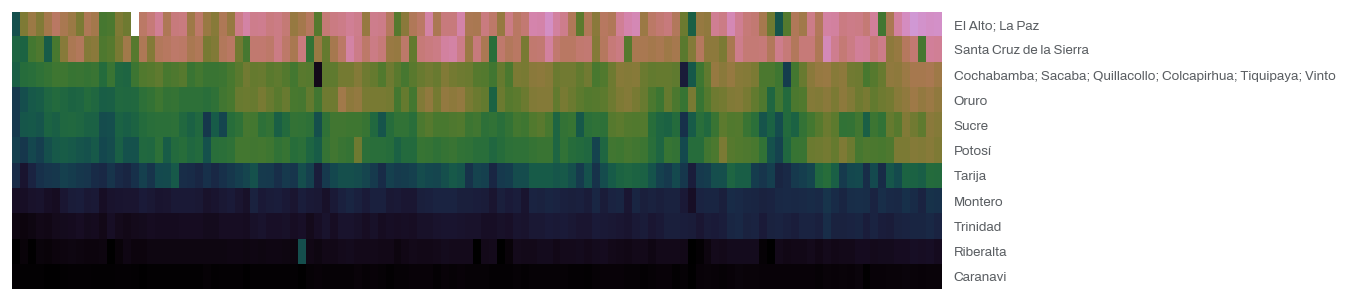

In [606]:
def plotTimeseriesCollectionJoined2(collection, ciudad_col='ciudad'):
    
    dfi = ciudades_mean.pivot_table(index='ciudad', columns='date', values='value')
    order = collection[collection.date == collection.date.max()].sort_values('value')[ciudad_col].tolist()
    dfi = dfi.loc[order,:]
    
    f, ax = plt.subplots(1,1,figsize=(10, 3), dpi=120)
    im = ax.imshow(dfi, cmap='cubehelix', aspect='auto',)
    ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.index)))))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(dfi.index))
    ax.yaxis.tick_right()
    ax.invert_yaxis()
    ax.set_xticklabels([])
    
plotTimeseriesCollectionJoined2(ciudades_mean)

In [608]:
ciudades_mean.to_csv('outputs/ciudades_mean_light.csv', index=False)

### Sum of lights for every city

Finally, we can compute the sum of lights for every city.

In [415]:
ciudades_sum = collectionTimeseries(ciudades, ee.Reducer.sum())

In [416]:
ciudades_sum

,ciudad,date,value
0,El Alto; La Paz,2014-01-01,33162.635447
1,Caranavi,2014-01-01,170.701888
2,Riberalta,2014-01-01,0.000000
3,Oruro,2014-01-01,10293.956282
4,Cochabamba; Sacaba; Quillacollo; Colcapirhua; ...,2014-01-01,42204.851875
...,...,...,...
1282,Potosí,2023-09-01,13854.205665
1283,Sucre,2023-09-01,13458.803693
1284,Tarija,2023-09-01,11993.800711
1285,Montero,2023-09-01,5111.682600


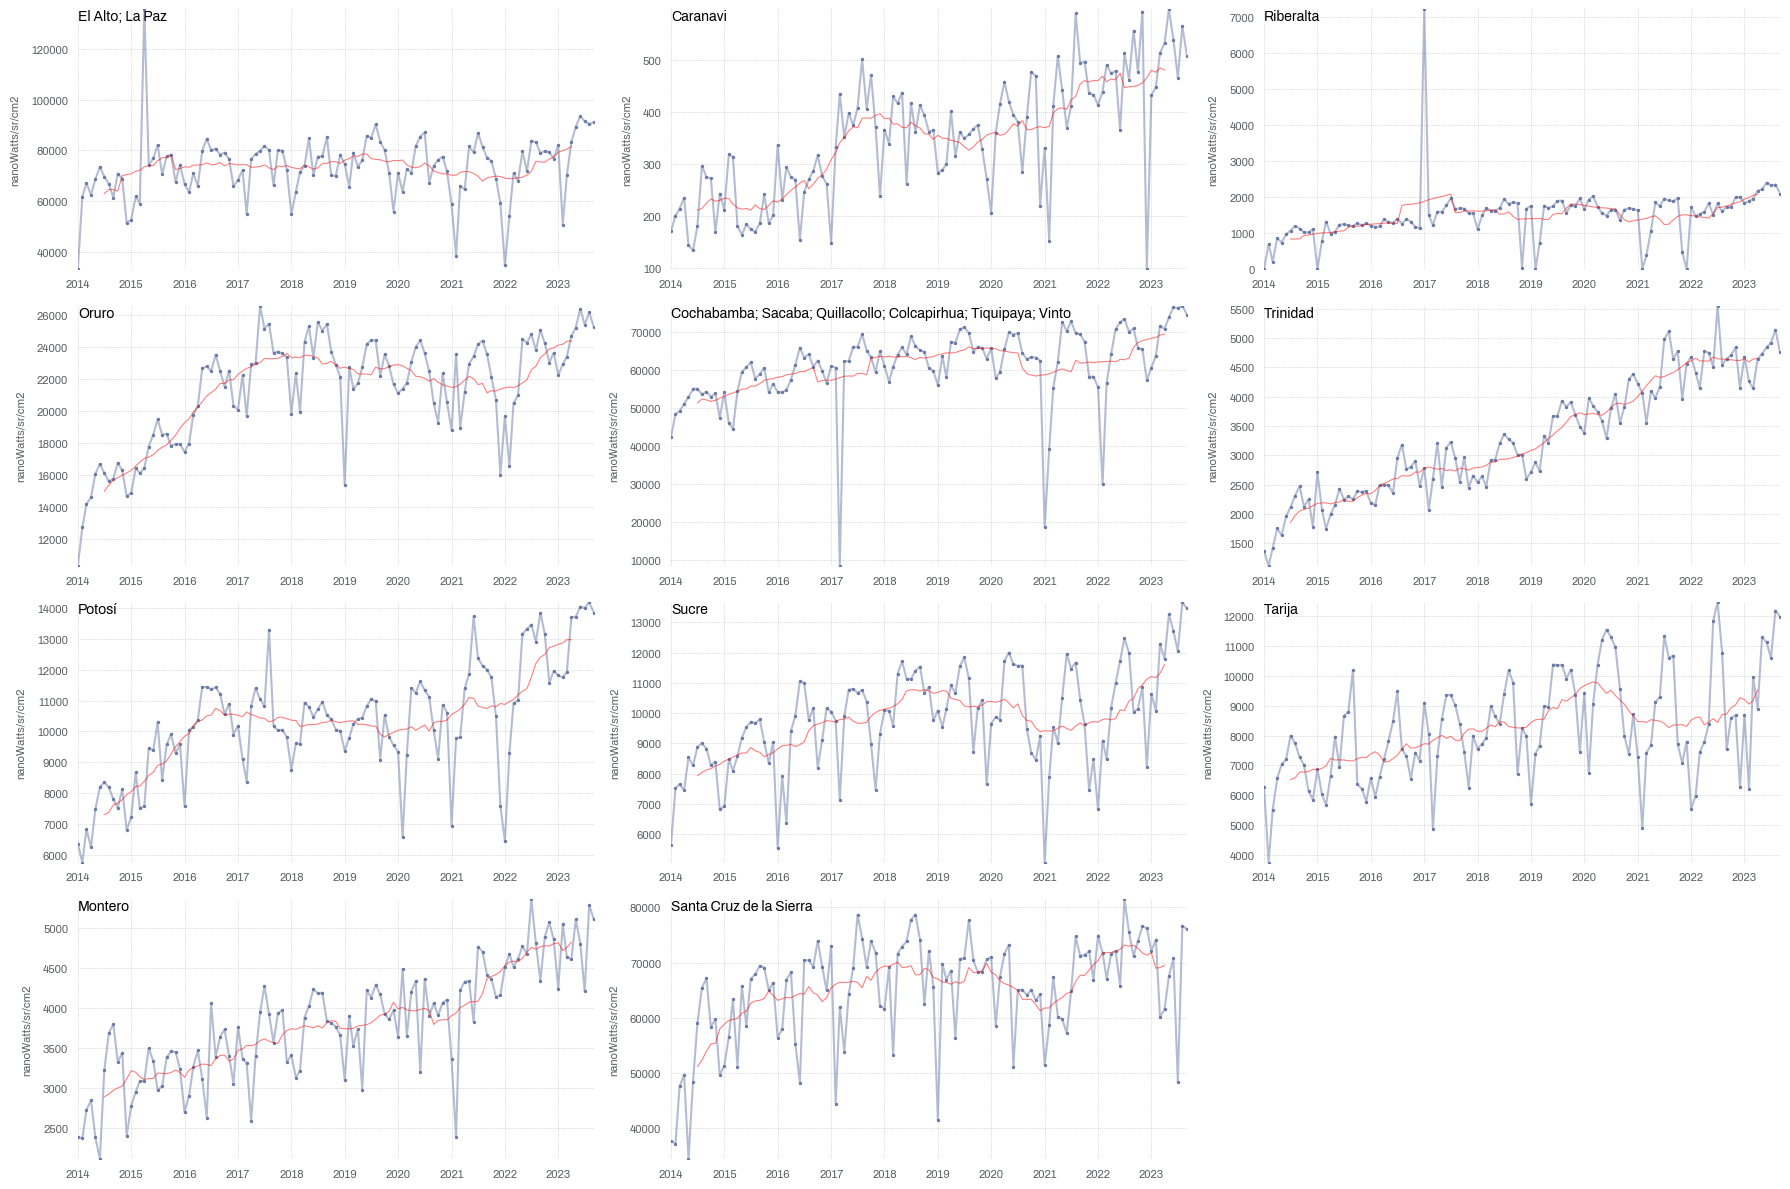

In [441]:
plotTimeseriesCollection(ciudades_sum, cols=3)

In [609]:
ciudades_sum.to_csv('outputs/ciudades_sum_light.csv', index=False)